In [1]:
!pip install transformers

In [2]:
import pandas as pd
df = pd.read_csv('dataset_stemming.csv')
df.head()

,tweet,label
0,jln jatibarupolisi tdk bs gertak gubernur eman...,anger
1,cewe lho kayak rasain sibuk jaga rasain sakit ...,anger
2,kepingin gudeg mbarek bu hj amad foto google s...,happy
3,jln jatibarubagian wilayah tn abangpengaturan ...,anger
4,sharing alam aja kemarin jam 1800 batalin tike...,happy


In [3]:
import torch
import numpy as np

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


In [4]:
df.loc[df['label'] == 'anger', 'labels'] = 1
df.loc[df['label'] =='happy', 'labels'] = 4
df.loc[df['label'] == 'sadness', 'labels'] = 0
df.loc[df['label'] =='fear', 'labels'] = 3
df.loc[df['label'] == 'love', 'labels'] = 2

In [5]:
del df['label']
df.head(5)

,tweet,labels
0,jln jatibarupolisi tdk bs gertak gubernur eman...,1.0
1,cewe lho kayak rasain sibuk jaga rasain sakit ...,1.0
2,kepingin gudeg mbarek bu hj amad foto google s...,4.0
3,jln jatibarubagian wilayah tn abangpengaturan ...,1.0
4,sharing alam aja kemarin jam 1800 batalin tike...,4.0


In [6]:
 df = df.rename(columns={"labels": "tagging"})

In [7]:
df.head(5)

,tweet,tagging
0,jln jatibarupolisi tdk bs gertak gubernur eman...,1.0
1,cewe lho kayak rasain sibuk jaga rasain sakit ...,1.0
2,kepingin gudeg mbarek bu hj amad foto google s...,4.0
3,jln jatibarubagian wilayah tn abangpengaturan ...,1.0
4,sharing alam aja kemarin jam 1800 batalin tike...,4.0


In [8]:
df.tweet[2]

'kepingin gudeg mbarek bu hj amad foto google sengaja biar teman jg bayang bagi indah'

In [9]:
df.tagging.value_counts()

1.0    1101
4.0    1017
0.0     997
3.0     649
2.0     637
Name: tagging, dtype: int64

In [10]:
tweet = df.tweet.values
labels = df.tagging.values

In [11]:
import re

def preprocess_text(sentence):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence.lower()

In [12]:
tweet_short = []

for index,sentences in enumerate(tweet):
  sentences = preprocess_text(sentences)
  temp_word = sentences.split()

  length = len(temp_word)

  if(length > 280):
    temp_word = temp_word[:280]

  tweet_short.append(temp_word)

In [13]:
tweet_short[0][len(tweet_short[0]) - 20:len(tweet_short[0])]

['jln',
 'jatibarupolisi',
 'tdk',
 'bs',
 'gertak',
 'gubernur',
 'emangny',
 'polisi',
 'tdk',
 'pmbhasan',
 'jgn',
 'politik',
 'atur',
 'wilayahhak',
 'gubernur',
 'tn',
 'abang',
 'turun',
 'temurunpelikperlu',
 'sabar']

In [14]:
len(tweet_short[0])

20

In [15]:
from transformers import BertTokenizer, BertConfig,AdamW, BertForSequenceClassification,get_linear_schedule_with_warmup, RobertaTokenizer, AutoTokenizer

model_name ='akahana/indonesia-emotion-roberta'
tokenizer = AutoTokenizer.from_pretrained(model_name)
input_id = [tokenizer.encode(sent,  add_special_tokens=True, max_length=280, truncation=True, padding='max_length') for sent in tweet]

  # is_split_into_words=True,  

In [16]:
attention_masks = [[float(i>0) for i in seq] for seq in input_id]

In [17]:
input_id[3][len(input_id[3])-1]

1

In [18]:
from sklearn.model_selection import train_test_split

# Split train and validation with 10:1 ratio
train_inputs, validation_input, train_labels, validation_labels  = train_test_split(input_id, labels,random_state=32, test_size=0.1)
# We only need to split attention mask into 2 variable, labels is not needed for this.
train_masks, validation_masks, label_mask,_  = train_test_split(attention_masks, labels,random_state=32, test_size=0.1)

# From the train_input, split again to train and prediction with 10:1 ratio
train_inputs, prediction_input, train_labels, prediction_labels  = train_test_split(train_inputs, train_labels,random_state=3, test_size=0.2)
train_masks, prediction_masks, _,_  = train_test_split(train_masks, label_mask,random_state=3, test_size=0.2)

In [19]:
import torch

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_input)
prediction_input = torch.tensor(prediction_input)

train_labels = torch.tensor(train_labels, dtype=torch.long)
validation_labels = torch.tensor(validation_labels, dtype=torch.long)
prediction_labels = torch.tensor(prediction_labels, dtype=torch.long)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)
prediction_masks = torch.tensor(prediction_masks)

In [20]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 8

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

prediction_data = TensorDataset(prediction_input, prediction_masks, prediction_labels)
prediction_sampler = RandomSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [21]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    model_name, 
    num_labels = 5, 
    hidden_dropout_prob = 0.1, 
    output_attentions = False, 
    output_hidden_states = False, 
)

model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

In [22]:
params = list(model.named_parameters())

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

classifier.dense.weight                                   (768, 768)
classifier.dense.bias                                         (768,)
classifier.out_proj.weight                                  (5, 768)
classifier.out_proj.bias                                        (5,)


In [23]:
optimizer = AdamW(model.parameters(), lr = 2e-5, eps=1e-8, correct_bias=False)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [24]:
from transformers import get_linear_schedule_with_warmup

epochs = 3

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

In [25]:
import numpy as np

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [26]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    elapsed_rounded = int(round((elapsed)))
    
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [27]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
train_loss_values = []
eval_loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs.loss

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    train_loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None,
                            labels=b_labels,
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs.logits

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        loss = outputs.loss

        eval_loss += loss.item()

        # Track the number of batches
        nb_eval_steps += 1

    avg_eval_loss = eval_loss / len(validation_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    eval_loss_values.append(avg_eval_loss)

        
    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print(" validation loss : {:.2f}".format(avg_eval_loss))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 3 ========
Training...
  Batch    40  of    396.    Elapsed: 0:00:35.
  Batch    80  of    396.    Elapsed: 0:01:10.
  Batch   120  of    396.    Elapsed: 0:01:45.
  Batch   160  of    396.    Elapsed: 0:02:20.
  Batch   200  of    396.    Elapsed: 0:02:55.
  Batch   240  of    396.    Elapsed: 0:03:30.
  Batch   280  of    396.    Elapsed: 0:04:05.
  Batch   320  of    396.    Elapsed: 0:04:40.
  Batch   360  of    396.    Elapsed: 0:05:15.

  Average training loss: 1.16
  Training epcoh took: 0:05:47

Running Validation...
  Accuracy: 0.68
 validation loss : 0.99
  Validation took: 0:00:16

======== Epoch 2 / 3 ========
Training...
  Batch    40  of    396.    Elapsed: 0:00:35.
  Batch    80  of    396.    Elapsed: 0:01:10.
  Batch   120  of    396.    Elapsed: 0:01:45.
  Batch   160  of    396.    Elapsed: 0:02:20.
  Batch   200  of    396.    Elapsed: 0:02:55.
  Batch   240  of    396.    Elapsed: 0:03:30.
  Batch   280  of    396.    Elapsed: 0:04:04.
  Batch  

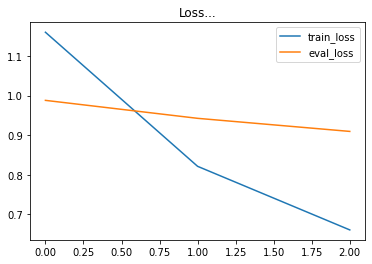

In [28]:
from matplotlib import pyplot as plt

plt.plot(train_loss_values, label="train_loss")
plt.plot(eval_loss_values, label="eval_loss")
plt.title('Loss...')
plt.legend(loc = 'best')
plt.show()

In [29]:
# Prediction on test set

#print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

test_acc = 0.0
test_f1 = 0.0

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labelstest
  predictions.append(logits)
  true_labels.append(label_ids)

In [30]:
# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

In [31]:
flat_true_labels = [item for sublist in true_labels for item in sublist]

In [32]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score

print(classification_report(flat_predictions, flat_true_labels))

              precision    recall  f1-score   support

           0       0.51      0.57      0.54       154
           1       0.80      0.69      0.74       236
           2       0.81      0.78      0.79       116
           3       0.64      0.79      0.70        98
           4       0.74      0.73      0.73       188

    accuracy                           0.70       792
   macro avg       0.70      0.71      0.70       792
weighted avg       0.71      0.70      0.70       792



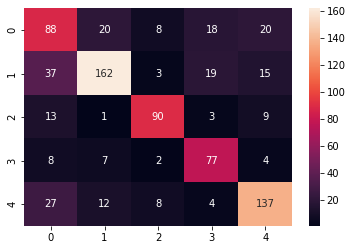

In [33]:
import seaborn as sns

cf_matrix = confusion_matrix(flat_predictions, flat_true_labels)
plt.figure()
sns.heatmap(cf_matrix, annot=True, fmt='d')